
### 1. Import necessary libraries

In this first step, we import the required Python libraries for numerical computations, data manipulation, plotting, and building thermal modeling using the `dm4bem` library.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import dm4bem



### 2. Load the thermal circuit model and convert to state-space representation

We load a thermal circuit from a CSV file and convert it into a state-space representation (A, B, C, D matrices), which is more suitable for numerical simulations.


In [2]:

TC = dm4bem.file2TC('./model/TC.csv', name='', auto_number=False)
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)



### 3. Define simulation parameters

We specify the simulation parameters such as whether a controller is used, whether the time step is imposed, and the value of the time step. These will guide the numerical integration.


In [3]:

controller = False
neglect_air_glass_capacity = True
imposed_time_step = True
Δt = 4000  # s



### 4. Compute system eigenvalues and determine numerical time step

We compute the eigenvalues of the state matrix to determine the maximum stable time step for an explicit Euler integration method, and also compute the total duration required for the system to reach steady state.


In [4]:

λ = np.linalg.eig(As)[0]
Δtmax = 2 * min(-1 / λ)
dm4bem.print_rounded_time('Δtmax', Δtmax)

dt = Δt if imposed_time_step else dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

t_settle = 4 * max(-1 / λ)
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)


Δtmax = 5171 s = 1.4 h
dt = 4000 s = 1.1 h
duration = 540000 s = 150.0 h



### 5. Generate synthetic constant input data

We create a simple scenario with constant indoor and outdoor temperatures and no solar or internal gains. This allows us to test the model's response under controlled conditions.


In [5]:

n = int(np.floor(duration / dt))
time = pd.date_range(start="2000-01-01 00:00:00", periods=n, freq=f"{int(dt)}s")

To = 10 * np.ones(n)
Ti = 22 * np.ones(n)
Φ0 = Φ1 = Φ2 = Φ3 = 0 * np.ones(n)

input_data_set = pd.DataFrame({
    'To': To, 'Ti': Ti,
    'Φ0': Φ0, 'Φ1': Φ1, 'Φ2': Φ2, 'Φ3': Φ3
}, index=time)



### 6. Prepare simulation inputs and initial temperatures

We format the inputs to match the expected format of the model, and initialize the indoor temperature using a fixed value.


In [6]:

u = dm4bem.inputs_in_time(us, input_data_set)

θ_exp = pd.DataFrame(index=u.index)
θ_imp = pd.DataFrame(index=u.index)
θ0 = 14

θ_exp[As.columns] = θ0
θ_imp[As.columns] = θ0



### 7. Perform numerical integration (explicit and implicit Euler methods)

We simulate the temperature evolution inside the building using both explicit and implicit Euler methods to compare their performance.


In [7]:

I = np.eye(As.shape[0])
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As) @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])



### 8. Visualize simulation results

We plot the indoor temperature evolution over time for both numerical methods to observe how the model behaves.


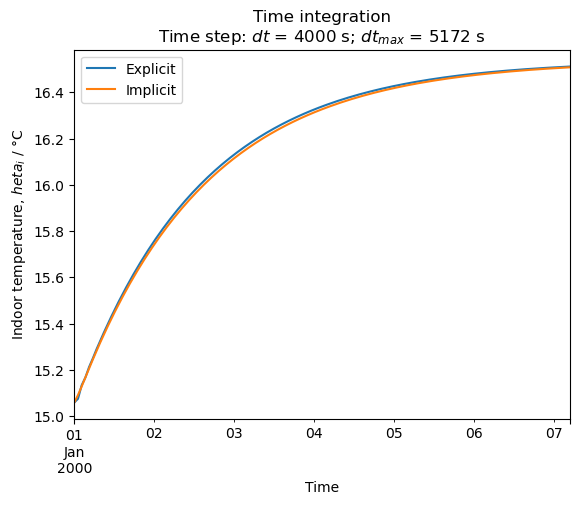

Steady-state indoor temperature obtained with:
- steady-state response to step input: 16.5116 °C


In [15]:

y_exp = (Cs @ θ_exp.T + Ds @ u.T).T
y_imp = (Cs @ θ_imp.T + Ds @ u.T).T

y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\theta_i$ / °C')
ax.set_title(f'Time integration\nTime step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

print('Steady-state indoor temperature obtained with:')
print(f'- steady-state response to step input: \
{y_exp["θ2"].tail(1).values[0]:.4f} °C')



## Import and Format Weather Data

We import real weather data from an EPW file, localize its datetime to the simulation year, and extract temperature and solar radiation. This provides realistic boundary conditions for the building model.


In [16]:
start_date = '05-01 12:00:00'
end_date = '05-07 12:00:00'

start_date = '2025-' + start_date
end_date = '2025-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2025))
weather = weather.loc[start_date:end_date]

To = weather['temp_air']


2025-05-01 12:00:00 	start date
2025-05-07 12:00:00 	end date



## Define Building Geometry and Materials

We define the geometry of the room and the physical properties of materials used in the construction. These are essential for determining heat transfer characteristics.


In [17]:

L, L2, H = 2.5, 2, 3
S_wall1 = L * H
S_wall2 = L2 * H
S_wall = S_wall1 + S_wall2
S_floor = S_roof = L**2
V_air = L**2 * H

E = 300
alphawout = 0.25
alphawindow = 0.38
alpharoof = alphafloor = 0.2

air = {'Density': 1.2, 'Specific heat': 1000}
concrete = {'Conductivity': 1.4, 'Density': 2300, 'Specific heat': 880, 'Width': 0.24, 'Surface': 3 * S_wall}
insulation = {'Conductivity': 0.027, 'Density': 55.0, 'Specific heat': 1210, 'Width': 0.06, 'Surface': 3 * S_wall}
glass = {'Conductivity': 1.4, 'Density': 2500, 'Specific heat': 1210, 'Width': 0.04, 'Surface': S_wall}
floor = {'Conductivity': 0.15, 'Density': 700, 'Specific heat': 1500, 'Width': 0.02, 'Surface': S_floor}
roof = {'Conductivity': 0.25, 'Density': 850, 'Specific heat': 1090, 'Width': 0.013, 'Surface': S_roof}

wall = pd.DataFrame.from_dict({'Concrete': concrete, 'Insulation': insulation, 'Glass': glass, 'Floor': floor, 'Roof': roof}, orient='index')



## Define Radiative and Convective Properties

We set radiative emissivities and convective heat transfer coefficients used in the heat balance equations.


In [20]:

ε_wLW, ε_gLW = 0.85, 0.90
σ = 5.67e-8
hi, ho = 8., 25.
λ_c, w_c = concrete['Conductivity'], concrete['Width']
λ_i, w_i = insulation['Conductivity'], insulation['Width']
λ_g, w_g = glass['Conductivity'], glass['Width']
λ_f, w_f = floor['Conductivity'], floor['Width']
λ_r, w_r = roof['Conductivity'], roof['Width']
S1, S2, S3 = S_wall1, S_wall2, S_wall1
S_floor = floor['Surface']
S_roof = roof['Surface']
S_door = S1 - S2
λ_door = 0.22
w_door = 0.04
S_wind = glass['Surface']

τ_gSW = 0.30



## Compute Solar Radiation on Tilted Surfaces

This section computes total solar radiation on surfaces using orientation parameters from a CSV file.


In [23]:

wall_out = pd.read_csv('./bldg/walls_out.csv')
w1 = wall_out[wall_out['ID'] == 'w0']
surface_orientation = {'slope': w1['β'].values[0], 'azimuth': w1['γ'].values[0], 'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, w1['albedo'].values[0])
Etot = rad_surf.sum(axis=1)

Φ0 = alphawindow * S1 * Etot  
Φ1 = alphawout * S1 * Etot 
Φ2 = alphafloor * S_roof * Etot    
Φ3 = alpharoof * S_roof * Etot



## Define Temperature Setpoint Profile

This section defines the indoor temperature setpoint profile for a typical daily cycle, with a higher setpoint during the day and a lower one at night.


In [22]:

Ti_day, Ti_night = 20, 16
Ti = pd.Series([Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour], index=To.index)



## Assemble Weather-Based Input Dataset

We compile all weather-based and solar inputs into a single DataFrame and save it to CSV for later reuse.


In [24]:

input_data_set = pd.DataFrame({'To': To, 'Ti': Ti, 'Φ0': Φ0, 'Φ1': Φ1, 'Φ2': Φ2, 'Φ3': Φ3, 'Etot': Etot})
input_data_set.to_csv('./model/input_data_set.csv')



## Plot Final Simulation Results

This section extracts and plots indoor and outdoor temperatures, ensuring the datetime index is timezone-naive for compatibility.


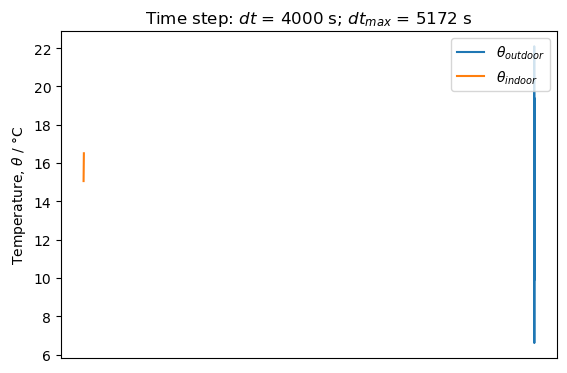

In [25]:

y = (Cs @ θ_exp.T + Ds @ u.T).T
input_data_set.index = input_data_set.index.tz_localize(None)

data = pd.DataFrame({
    'To': input_data_set['To'],
    'θi': y['θ2']
})

data.index = data.index.tz_localize(None)

fig, axs = plt.subplots(1, 1)
data[['To', 'θi']].plot(ax=axs, xticks=[], ylabel='Temperature, $θ$ / °C')
axs.legend(['$θ_{outdoor}$', '$θ_{indoor}$'], loc='upper right')
axs.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()
